In [1]:
from sklearn import model_selection
from sklearn import metrics
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn import model_selection
from sklearn import ensemble
from sklearn import linear_model as LM
import seaborn as sns
import pickle as pk
from matplotlib import pyplot as plt


# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')
out_dir = os.path.join(data_dir, 'results/AdaBoostCV_PCA_Healthy_v_ACVD')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv',
 'SampleMetaDataClean.csv',
 'SampleMetaDataManual.csv',
 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.shape

(4347, 38)

In [6]:
filter_indices = SampleMeta["Phenotype"].isin(['ACVD', 'Healthy'])
SampleMeta = SampleMeta[ filter_indices ]
SampleMeta.shape

(2788, 38)

In [7]:
MatrixData = MatrixData[ filter_indices ]
MatrixData.shape

(2788, 903)

In [8]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


In [9]:
X = MatrixData

In [10]:
y = SampleMeta['Healthy'].to_numpy().astype('str') == 'Healthy'
y = y.astype('int64')

# Define and Train Model

In [11]:
def RECALL_SCORE(y_pred, y_true):
    return(metrics.recall_score(y_pred, y_true, average='macro'))

retrain = True
n_splits = 5
out_path = os.path.join(out_dir, 'MyMultiTrainTester.pk')

if retrain:
    # clear previous results, if any
    if os.path.exists(out_dir):
        os.system('rm -rf ' + out_dir)
    os.mkdir(out_dir)
    # random seed here deals with model initialization
#     MyLogistic = LM.LogisticRegressionCV(random_state = 42, class_weight='balanced', Cs = np.exp(-np.arange(-10, 10)), 
#                                          solver='saga', penalty='elasticnet', l1_ratios=np.arange(0, 1.10, 0.10),
#                                         scoring=metrics.make_scorer(RECALL_SCORE))
#     logistic_model = LM.LogisticRegression(random_state=69, 
#                                            class_weight='balanced', 
#                                            C=0.006737946999085467,
#                                           l1_ratio=0.1,
#                                           solver='saga')
#     clf = ensemble.AdaBoostClassifier(base_estimator=logistic_model)
    clf = ensemble.AdaBoostClassifier(base_estimator=None)
    param_grid = {'n_estimators': [3, 5, 10]}
    model = model_selection.GridSearchCV(clf, param_grid, scoring = metrics.make_scorer(RECALL_SCORE), cv = 5)
    MyTrainer = Trainer(model = model, scale_X = True, use_pca = True, n_components=100)
    # random seed used in class definition is not used in final output models
    MyTrainTester = TrainTester(MyTrainer, RECALL_SCORE)
    # note that random seed here affects sequence of seeds passed to making new TrainTester objects
    # using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
    # across all data splits
    MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)
    MyMultiTrainTester.train(X, y)
    # save results
    outfile = open(out_path,'wb')
    pk.dump(MyMultiTrainTester, outfile)
    outfile.close()
    
else:
    # load previous results
    infile = open(out_path,'rb')
    MyMultiTrainTester = pk.load(infile)
    infile.close()
    


Running for split 1 of 5
Using predict_proba
getting predictions from probs
Running for split 2 of 5
Using predict_proba
getting predictions from probs
Running for split 3 of 5
Using predict_proba
getting predictions from probs
Running for split 4 of 5
Using predict_proba
getting predictions from probs
Running for split 5 of 5
Using predict_proba
getting predictions from probs


In [12]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.800565,train
1,0.840836,train
2,0.846775,train
3,0.826903,train
4,0.769974,train
0,0.757904,test
1,0.766490,test
2,0.758712,test
3,0.757407,test
4,0.729092,test


<AxesSubplot:xlabel='stage', ylabel='score'>

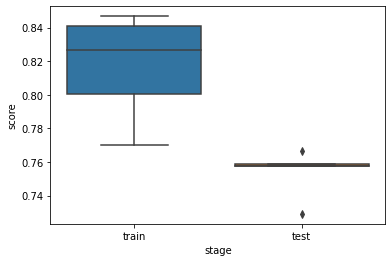

In [13]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

In [14]:
hyperparams = {'n_estimators': []}
for i in range(n_splits):
    hyperparams['n_estimators'].append(MyMultiTrainTester.TrainerList[i].model.best_params_['n_estimators'])

In [15]:
pd.DataFrame(hyperparams)

,n_estimators
0,10
1,10
2,10
3,10
4,3


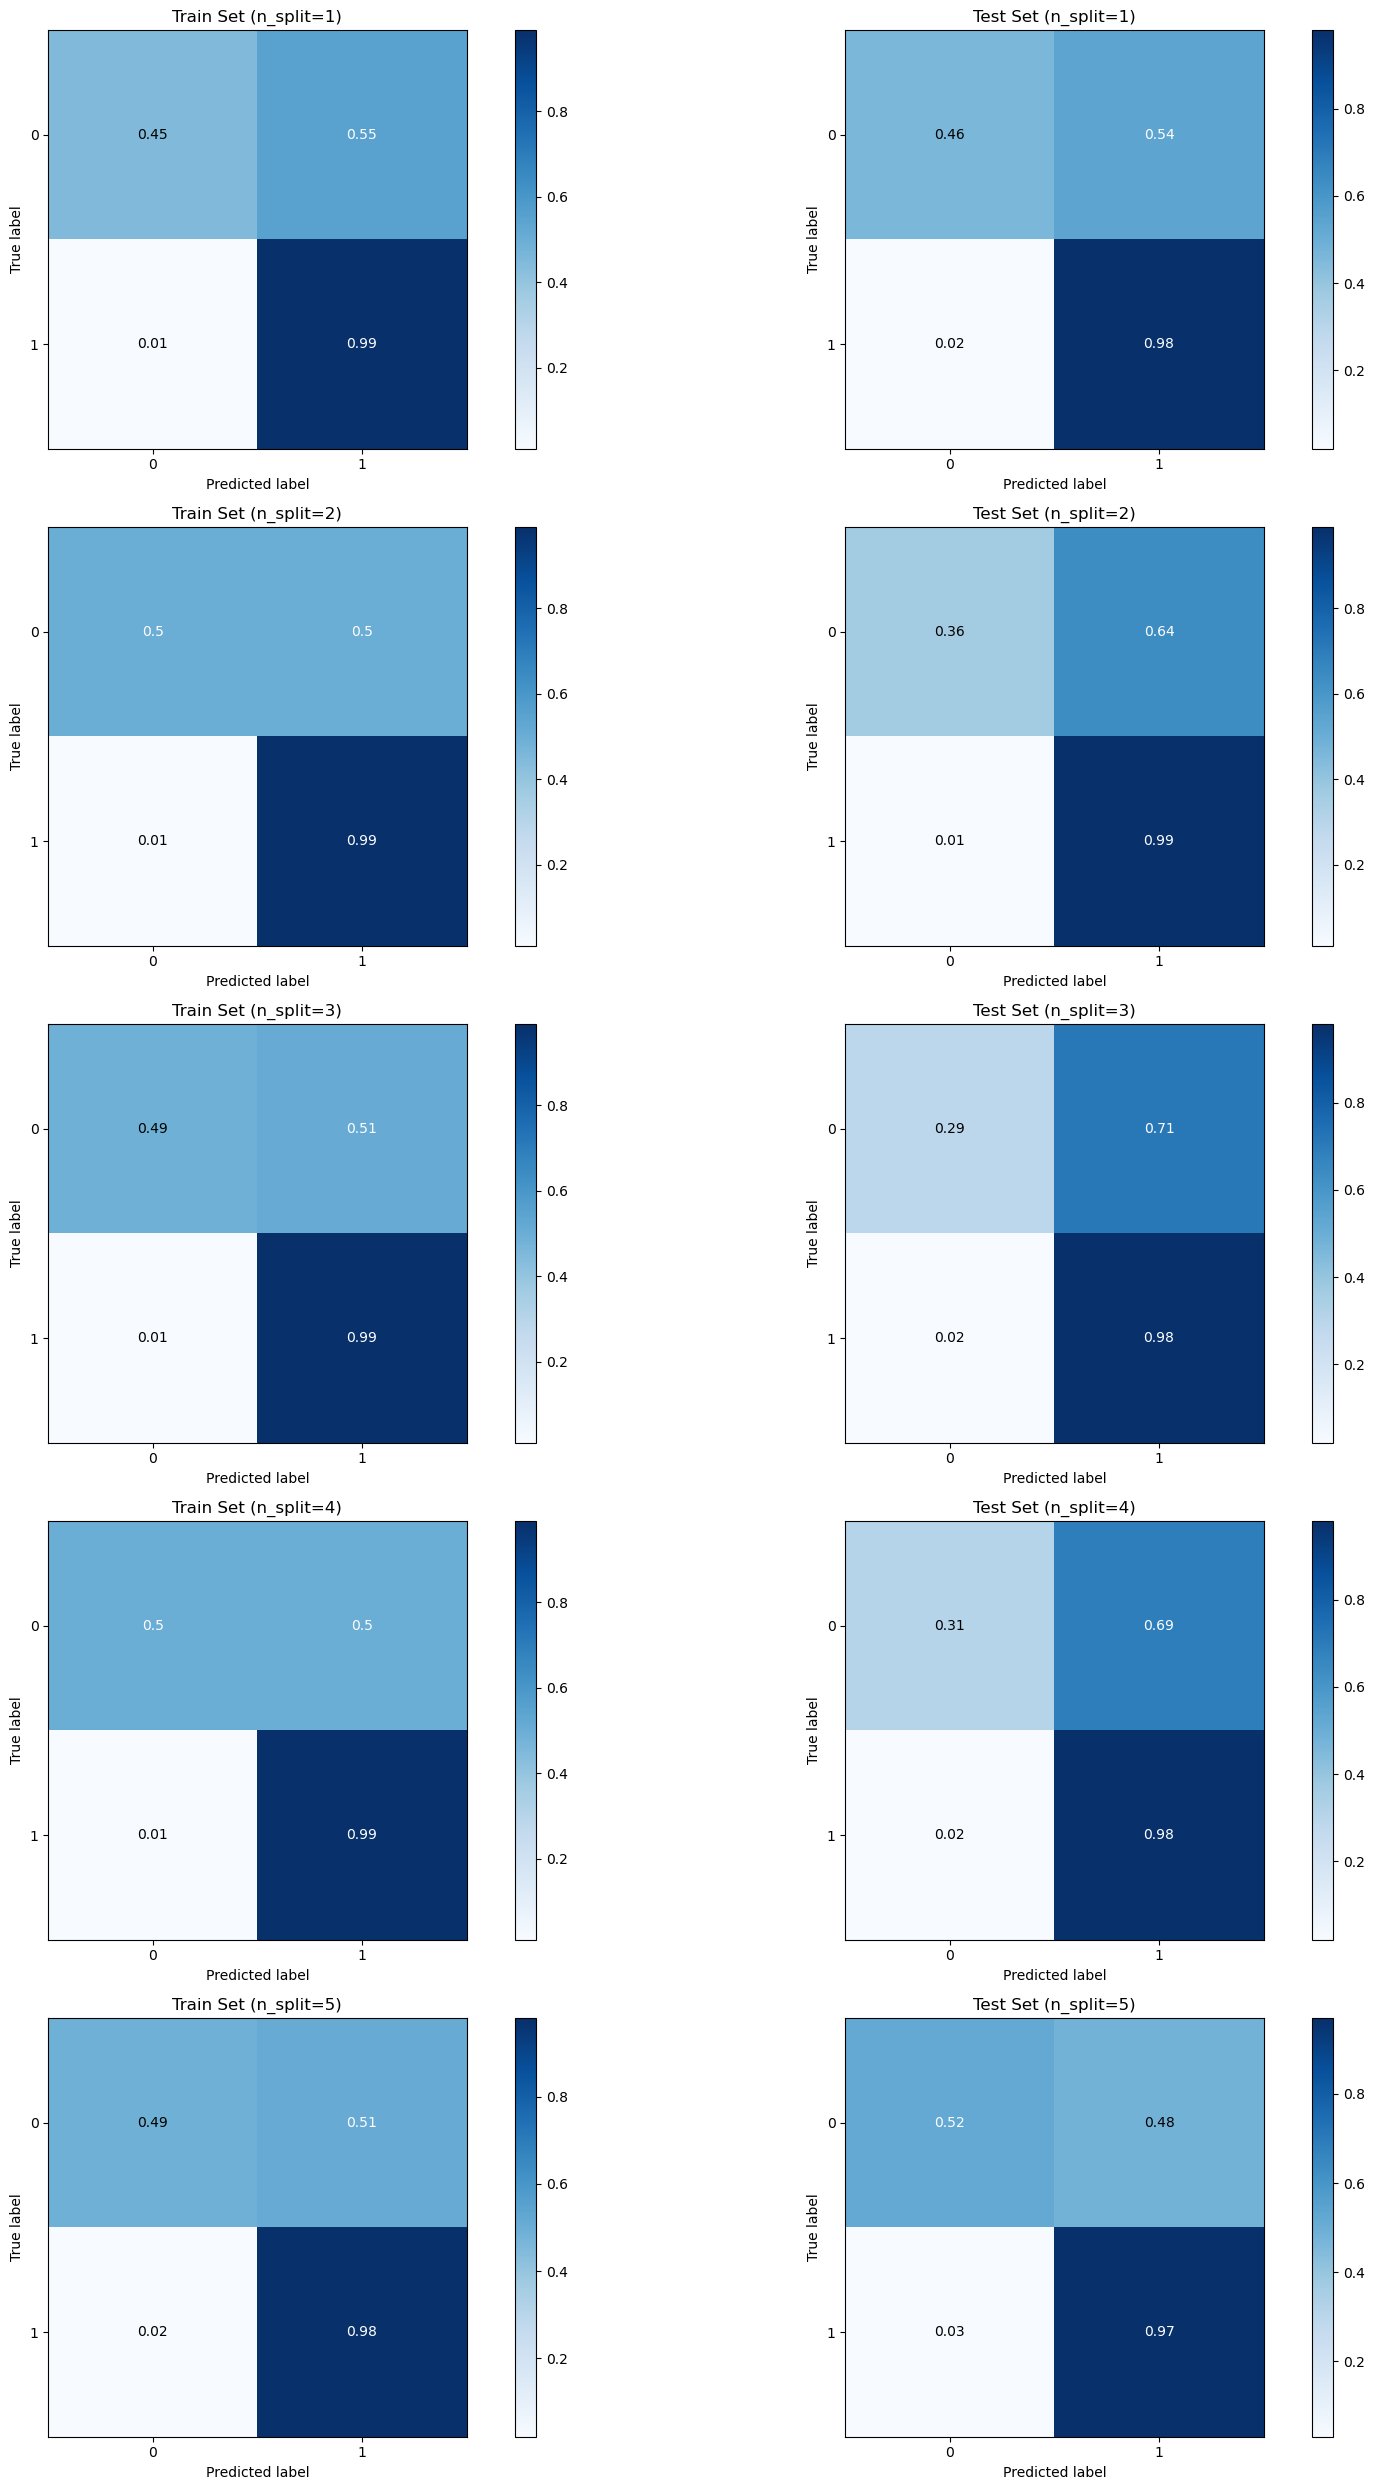

In [16]:
MyMultiTrainTester.plot_confusion(normalize=True)

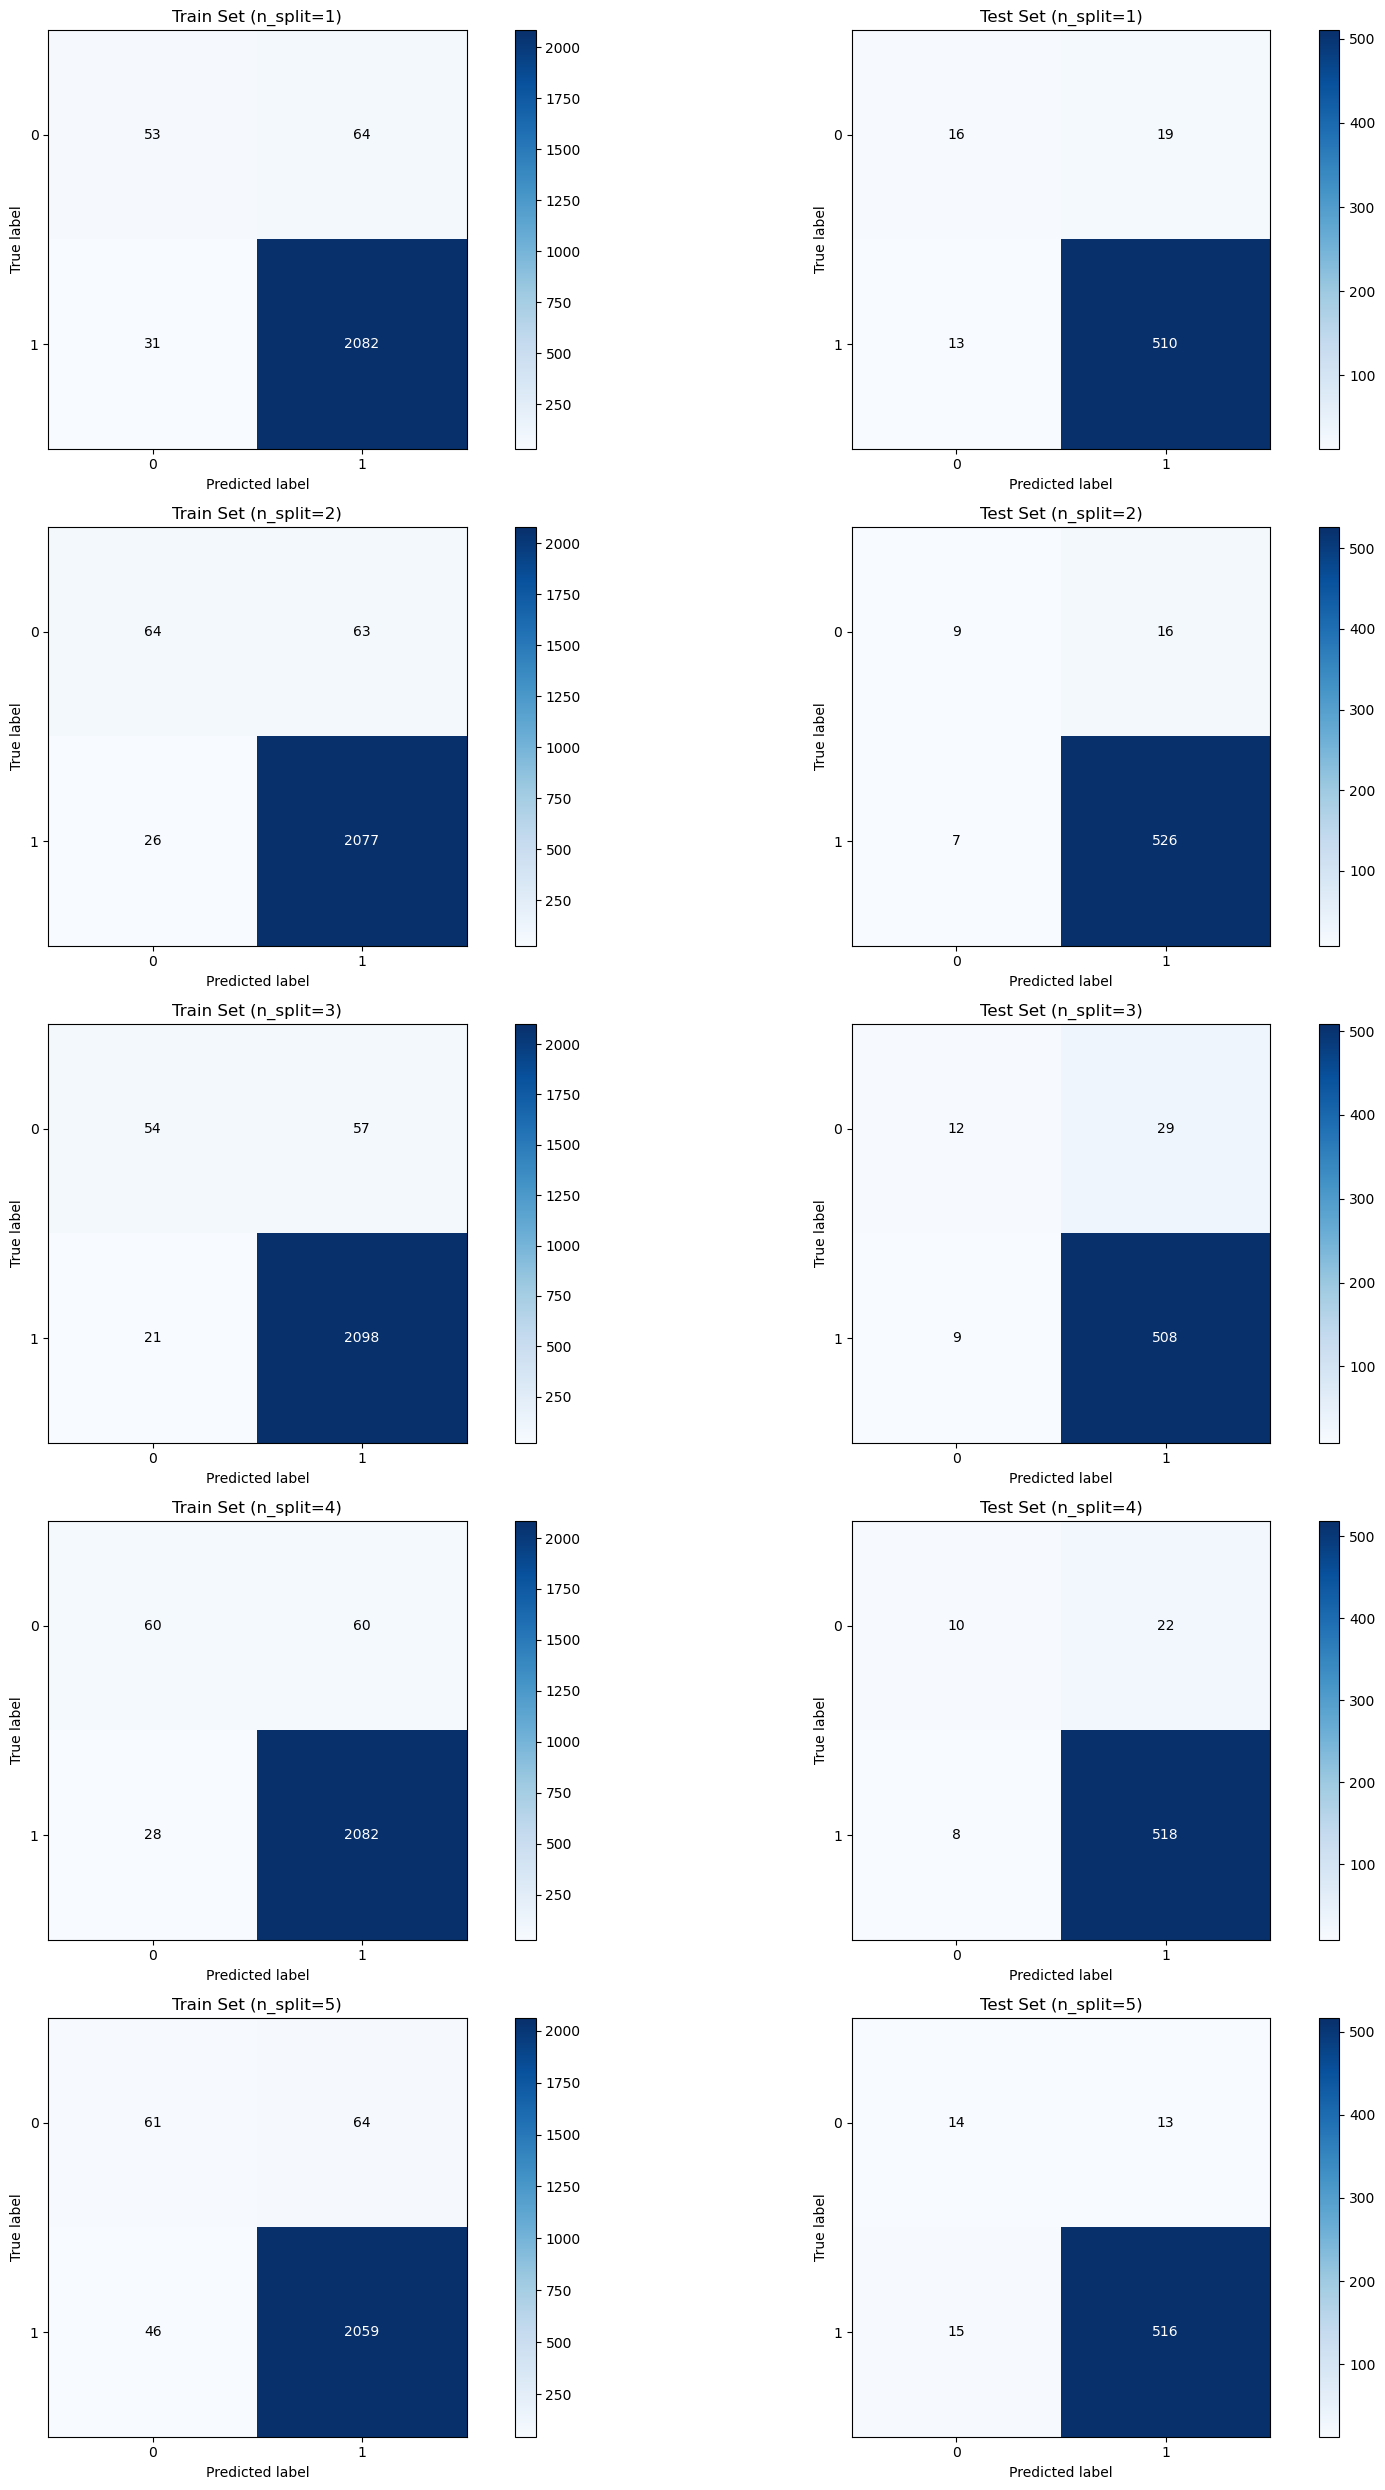

In [17]:
MyMultiTrainTester.plot_confusion(normalize=False)

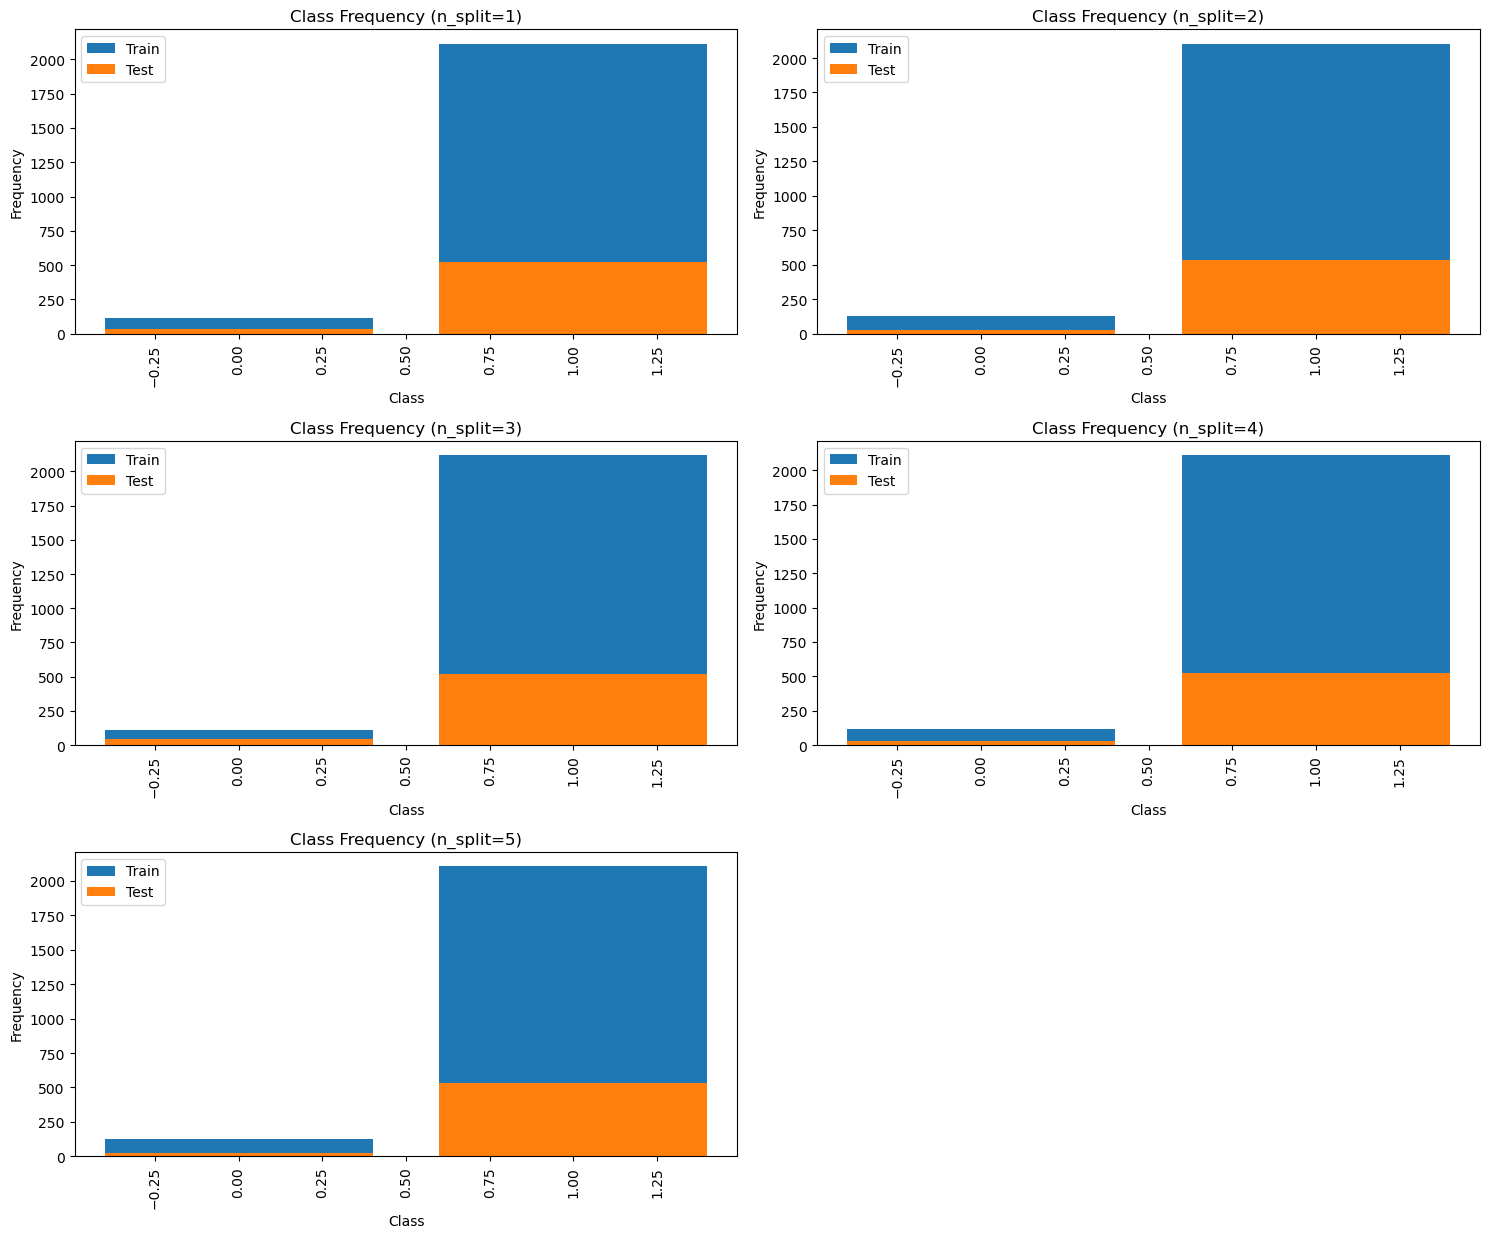

In [18]:
MyMultiTrainTester.plot_class_freq(normalize=True)

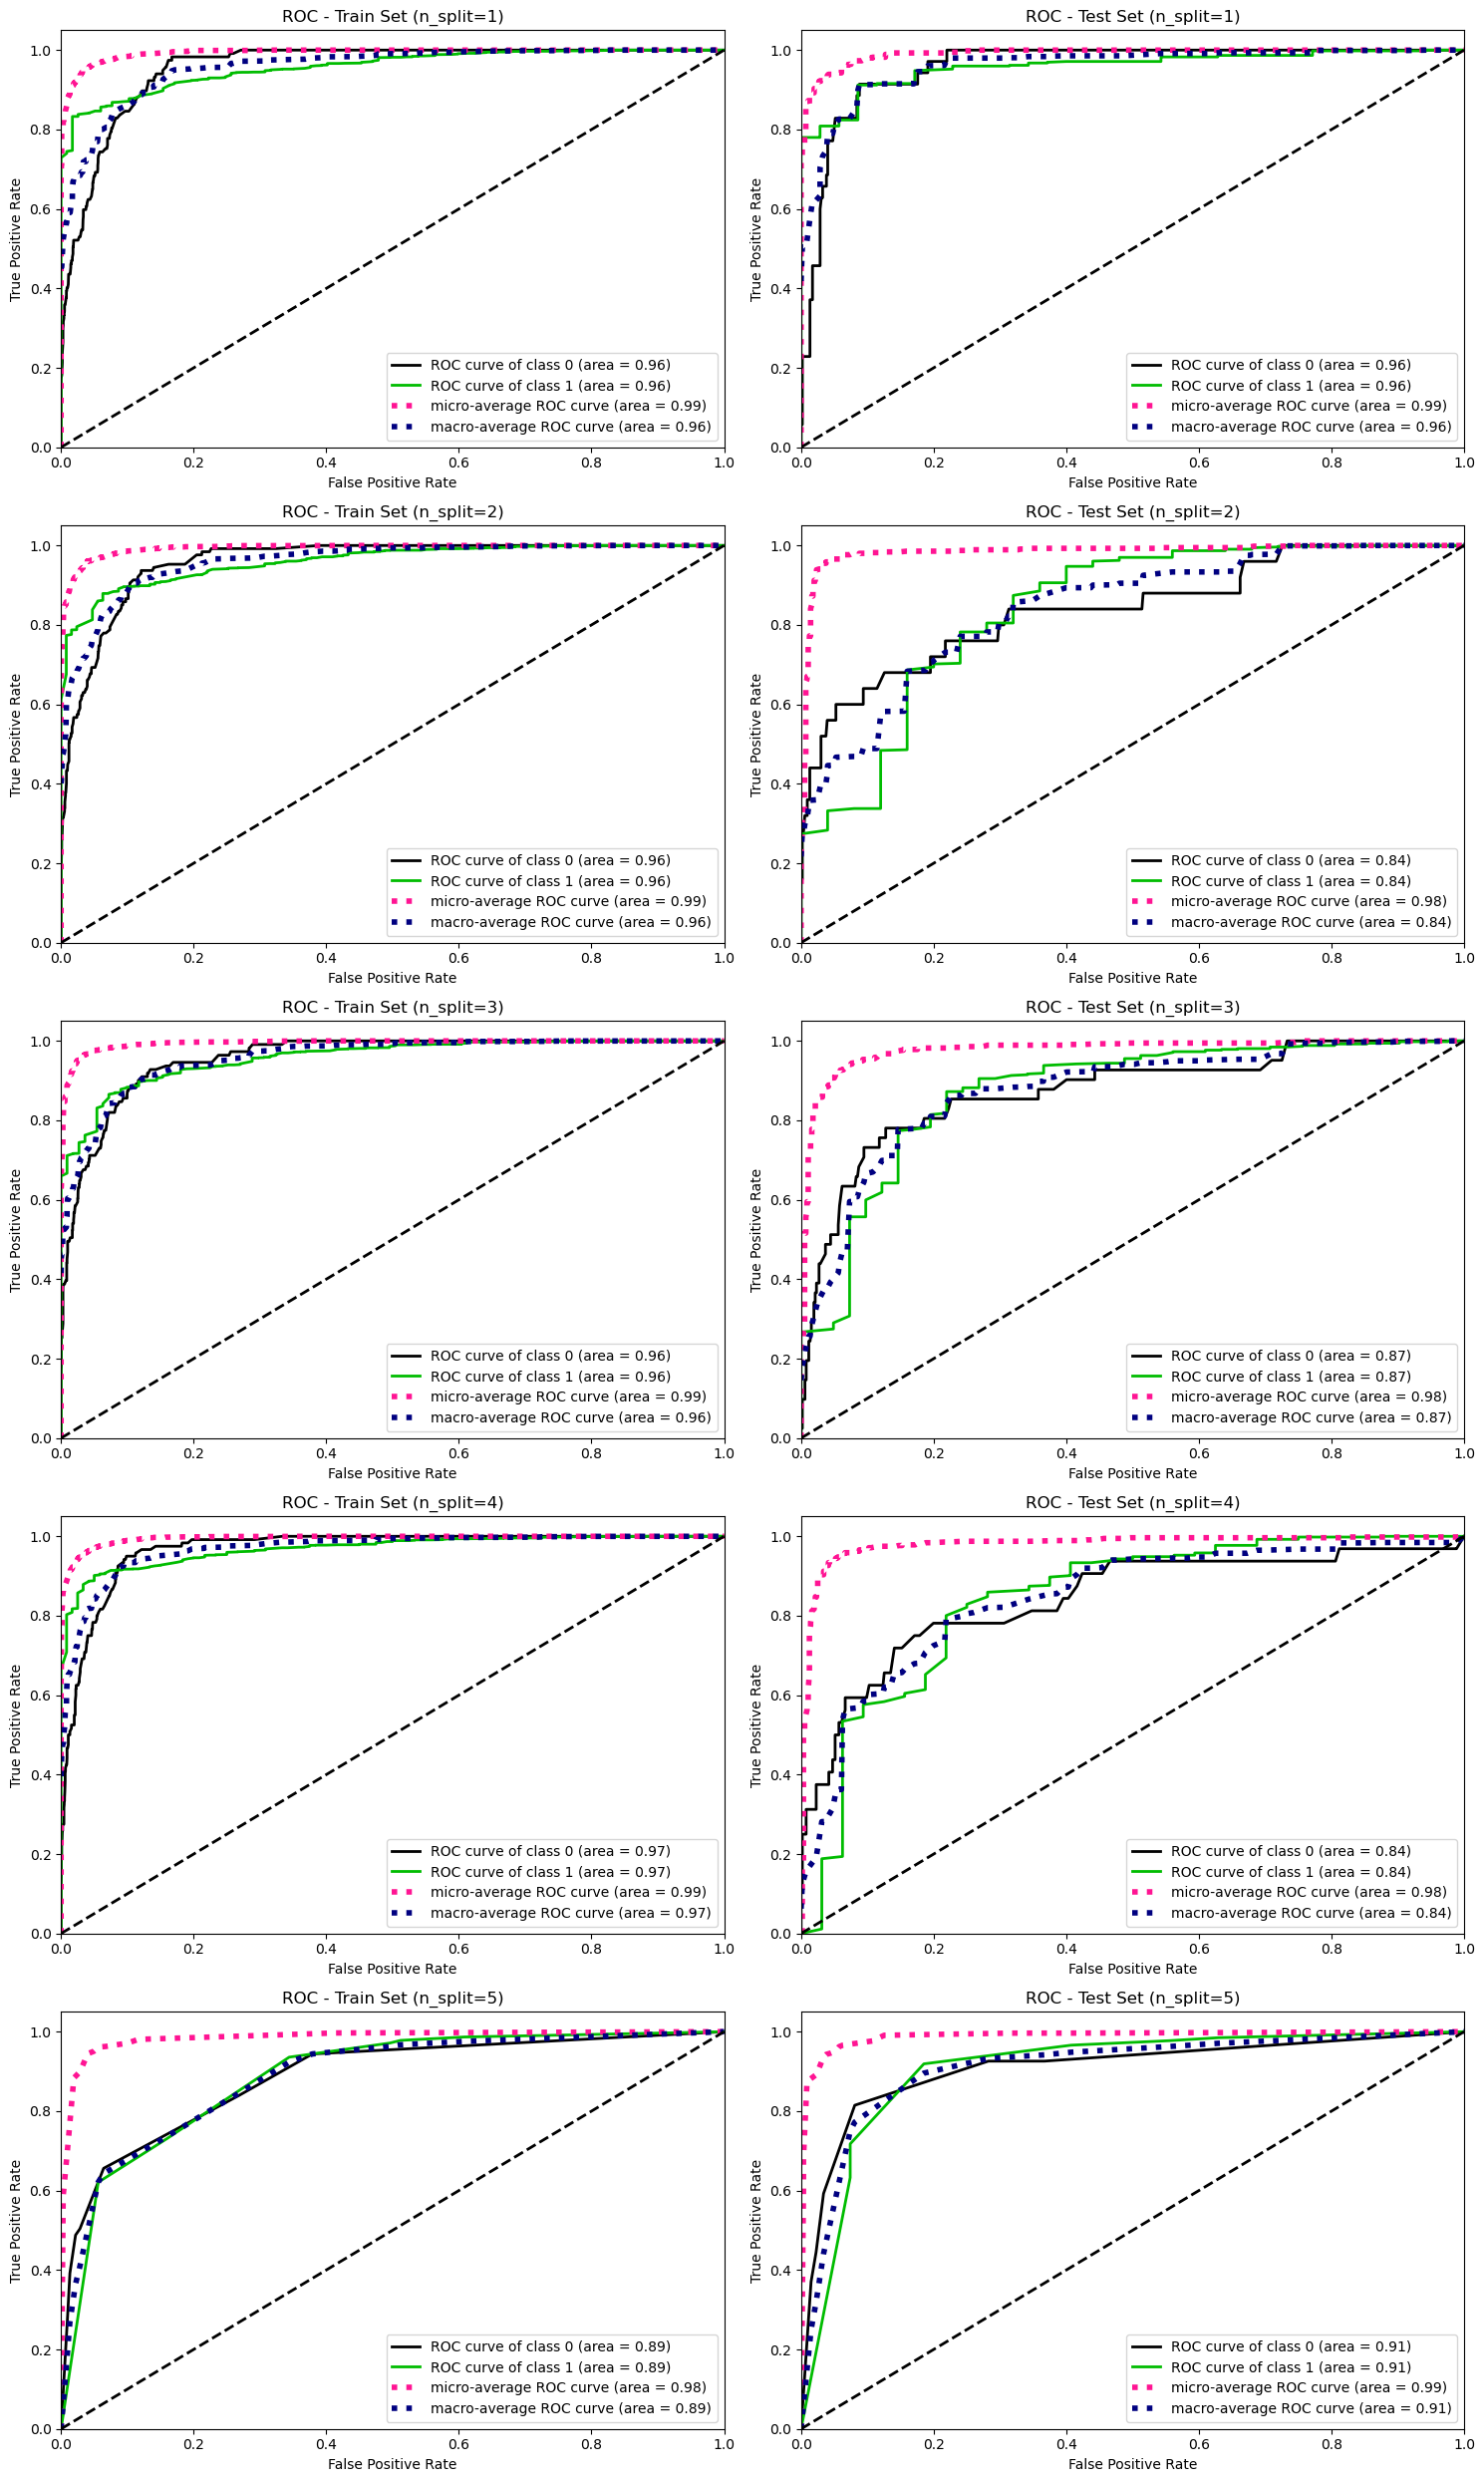

In [19]:
MyMultiTrainTester.plot_roc()

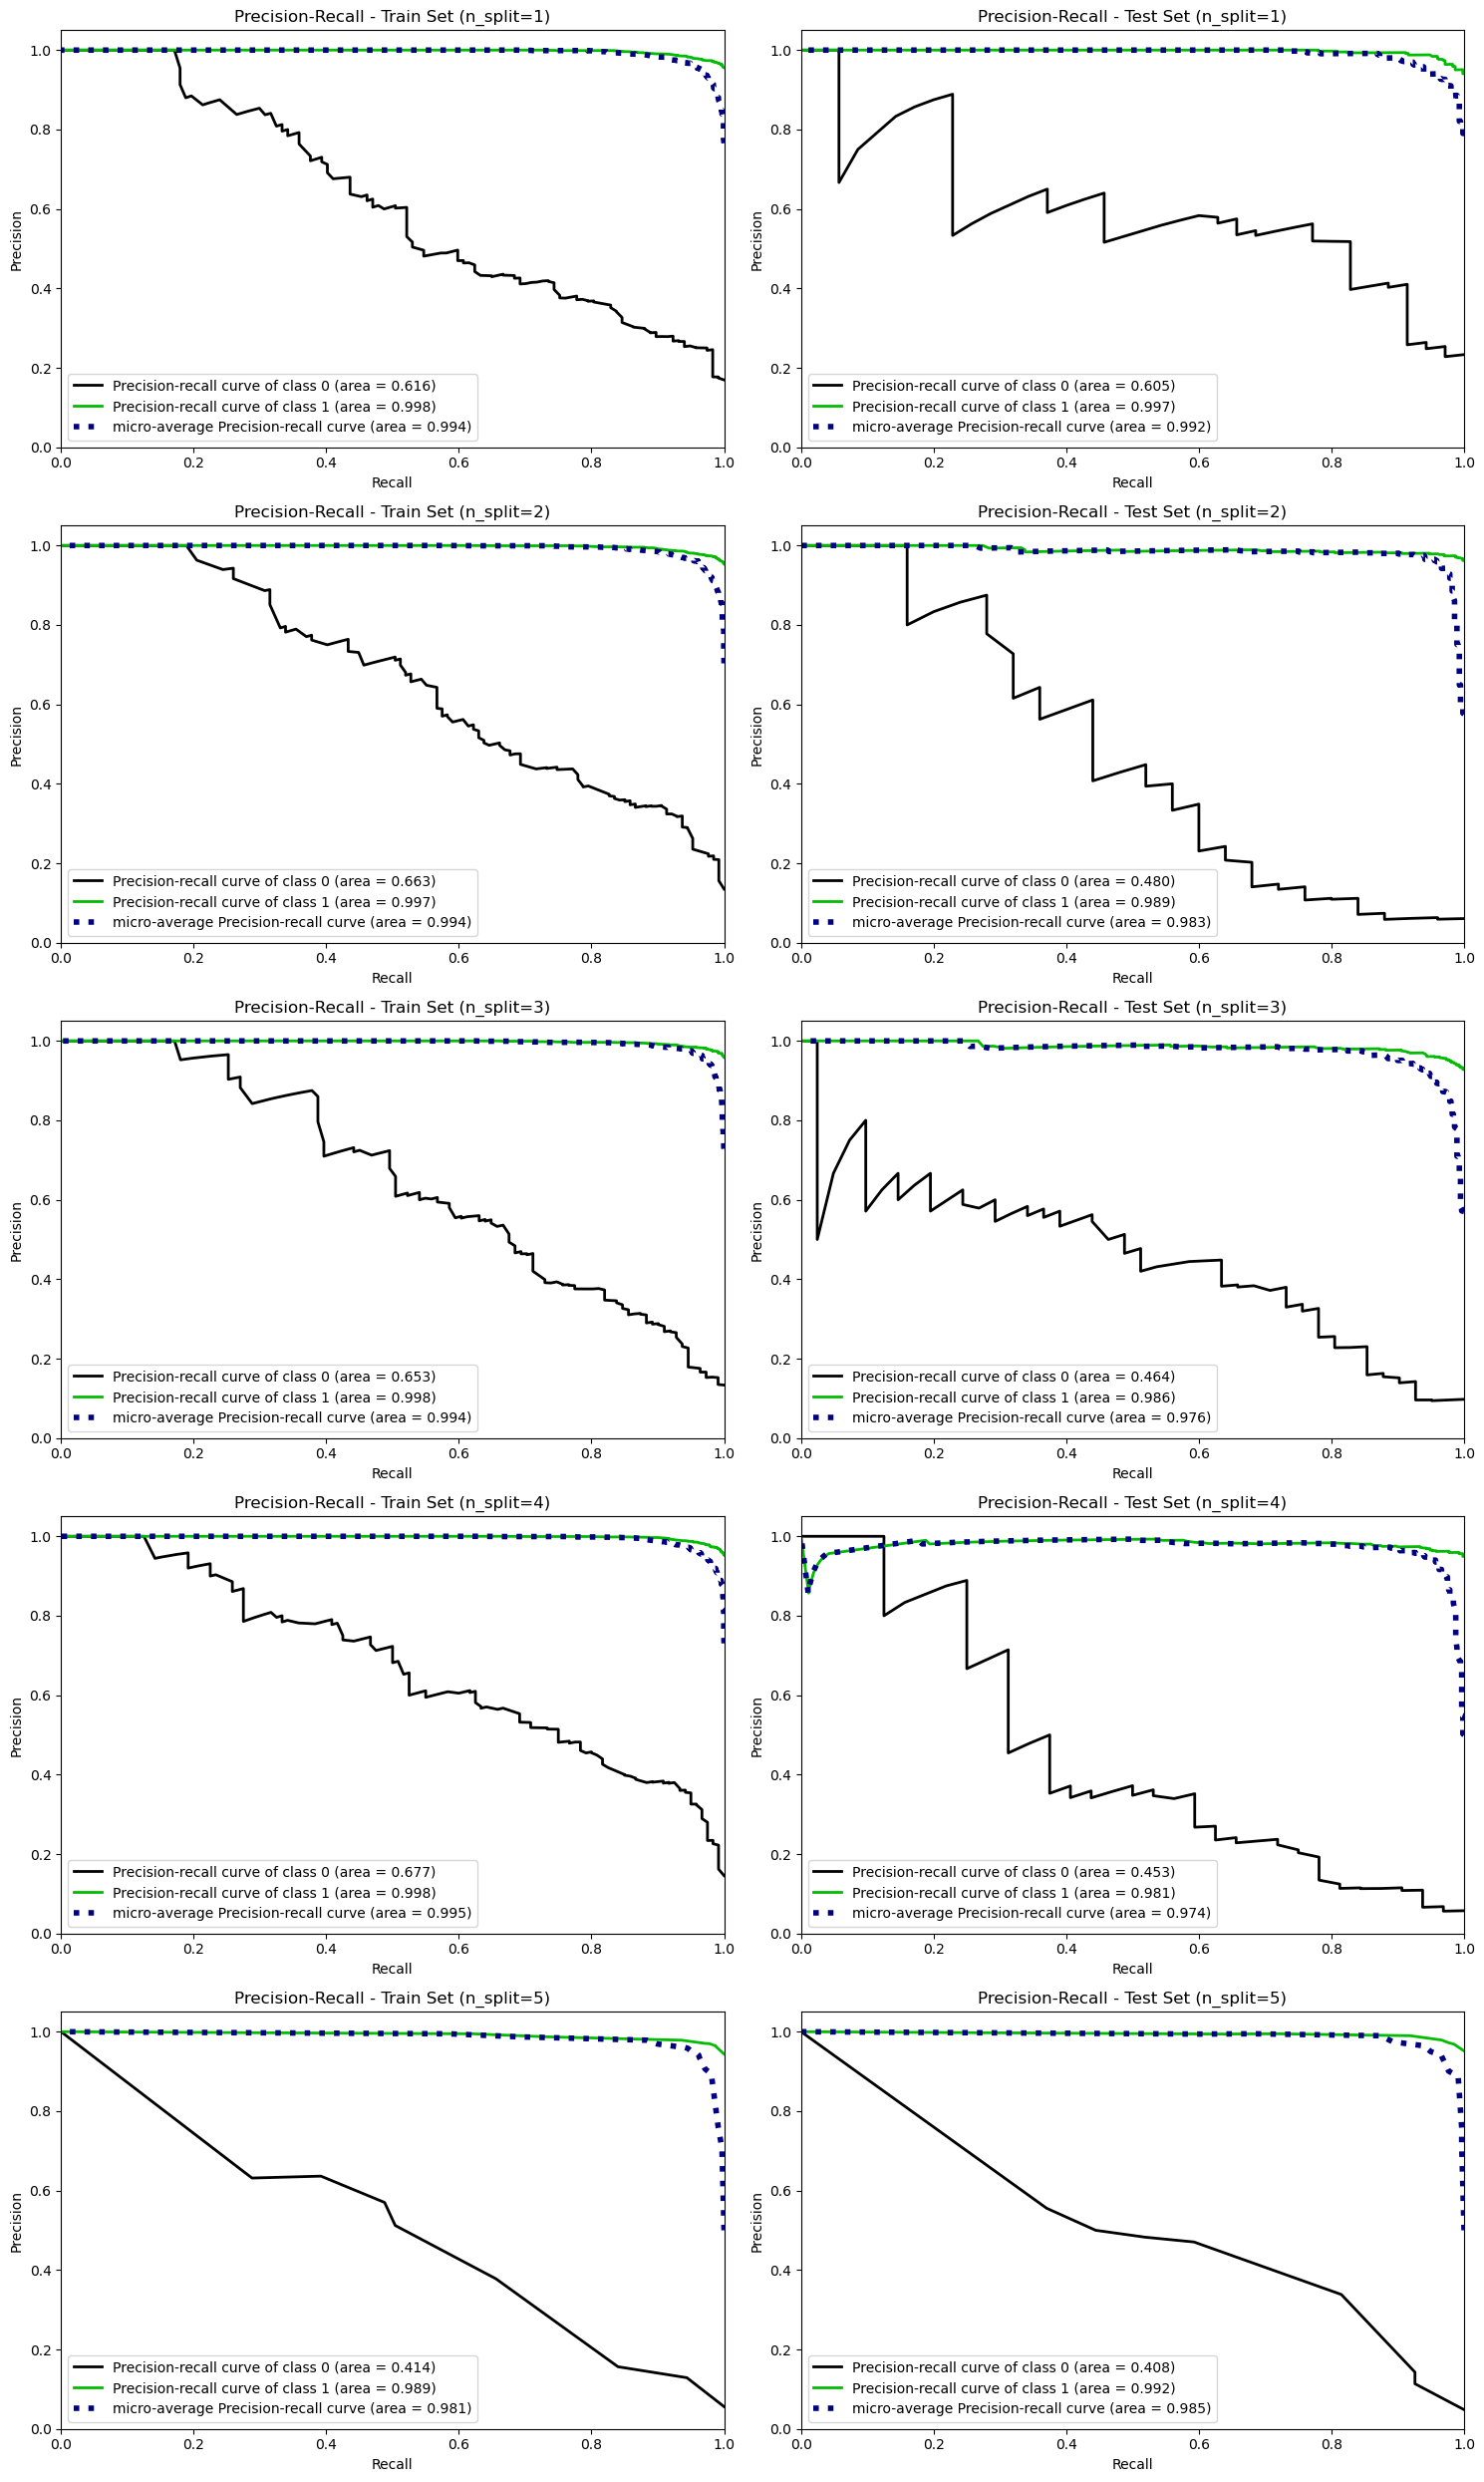

In [20]:
MyMultiTrainTester.plot_precrecall()

# Evaluate Model Performance on ACVD Study Data Only

In [21]:
FinalModel = MyMultiTrainTester.TrainerList[0]

In [22]:
train_idx0 = MyMultiTrainTester.train_idx[0]
test_idx0 = MyMultiTrainTester.test_idx[0]
SampleMetaTrain = SampleMeta.iloc[train_idx0, :]
SampleMetaTest = SampleMeta.iloc[test_idx0, :]

In [23]:
# get indices
train_idx_study = np.argwhere((SampleMetaTrain['Study Accession'] == 'PRJEB21528').to_numpy()).flatten()
test_idx_study = np.argwhere((SampleMetaTest['Study Accession'] == 'PRJEB21528').to_numpy()).flatten()

In [24]:
# check metadata
SampleMetaTrain.iloc[train_idx_study, :]['Gender'].value_counts()

M    111
F     68
Name: Gender, dtype: int64

In [25]:
SampleMetaTest.iloc[test_idx_study, :]['Gender'].value_counts()

M    34
F    14
Name: Gender, dtype: int64

In [26]:
np.sum(SampleMetaTrain.iloc[train_idx_study, :]['BMI'].to_numpy() == -99)

6

In [27]:
np.sum(SampleMetaTest.iloc[test_idx_study, :]['BMI'].to_numpy() == -99)

2

In [28]:
# Setup data for evaluation
X_train_study = X[train_idx0, :][train_idx_study, :]
y_train_study = y[train_idx0][train_idx_study]
X_test_study = X[test_idx0, :][test_idx_study, :]
y_test_study = y[test_idx0][test_idx_study]

## Train

In [29]:
FinalModel.score(X_train_study, y_train_study, RECALL_SCORE)

0.6539150813344362

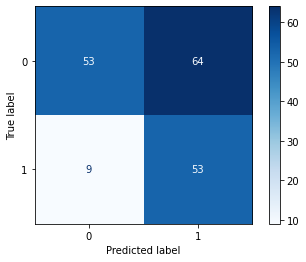

In [30]:
X_train_study_transf = FinalModel.transform_X(X_train_study)
metrics.plot_confusion_matrix(FinalModel.model, X_train_study_transf, y_train_study, cmap=plt.cm.Blues)

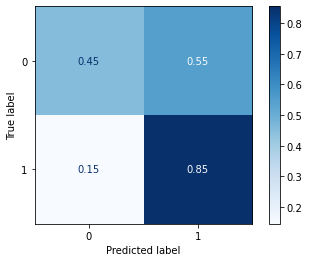

In [31]:
metrics.plot_confusion_matrix(FinalModel.model, X_train_study_transf, y_train_study, cmap=plt.cm.Blues, normalize='true')

## Test

In [32]:
FinalModel.score(X_test_study, y_test_study, RECALL_SCORE)

0.6277777777777778

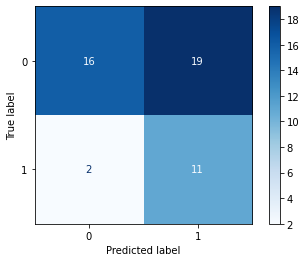

In [33]:
X_test_study_transf = FinalModel.transform_X(X_test_study)
metrics.plot_confusion_matrix(FinalModel.model, X_test_study_transf, y_test_study, cmap=plt.cm.Blues)

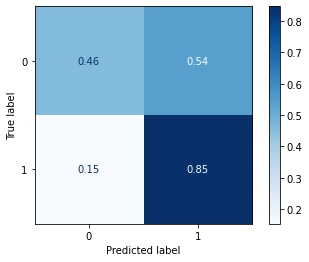

In [34]:
metrics.plot_confusion_matrix(FinalModel.model, X_test_study_transf, y_test_study, cmap=plt.cm.Blues, normalize='true')